# Part 3.2: Transfer Learning with BiG-Transfer (BiT) using TensorFlow Hub

This notebook demonstrates transfer learning with BiG-Transfer (BiT), a state-of-the-art model from TensorFlow Hub. We'll use BiT for image classification on the Flowers dataset.

## Installing Required Libraries
Installing TensorFlow datasets to load the Flowers dataset and TensorFlow Hub to access pre-trained models.

In [10]:
# Install required libraries
!pip install tensorflow-datasets tensorflow-hub

## Import Libraries and Set Seed
Importing necessary TensorFlow libraries for working with datasets, pre-trained models from TensorFlow Hub, and visualization tools.

In [2]:
# Import required libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
tf.random.set_seed(42)

## Load the Flowers Dataset
Load the TensorFlow Flowers dataset and split it into training and validation sets (80-20 split).

In [3]:
# Load the flowers dataset
dataset_name = "tf_flowers"
batch_size = 32

# Load the dataset
(train_ds, validation_ds), dataset_info = tfds.load(
   dataset_name,
   split=["train[:80%]", "train[80%:]"],
   with_info=True,
   as_supervised=True,
)

# Get number of classes
num_classes = dataset_info.features["label"].num_classes
print(f"Number of classes: {num_classes}")
print(f"Class names: {dataset_info.features['label'].names}")

Number of classes: 5
Class names: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


## Preprocess Dataset
Define preprocessing pipeline to resize images to 224x224 and normalize pixel values. Apply batching and shuffling for efficient training.

In [4]:
# Define preprocessing functions
IMG_SIZE = 224  # BiT works with 224x224 images

def preprocess_image(image, label):
   # Resize and rescale image
   image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
   image = image / 255.0  # Normalize to [0, 1]
   return image, label

# Apply preprocessing and create batches
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

validation_ds = validation_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_ds = validation_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Visualize Dataset
Display a 3x3 grid of sample images from the training dataset with their corresponding class labels.

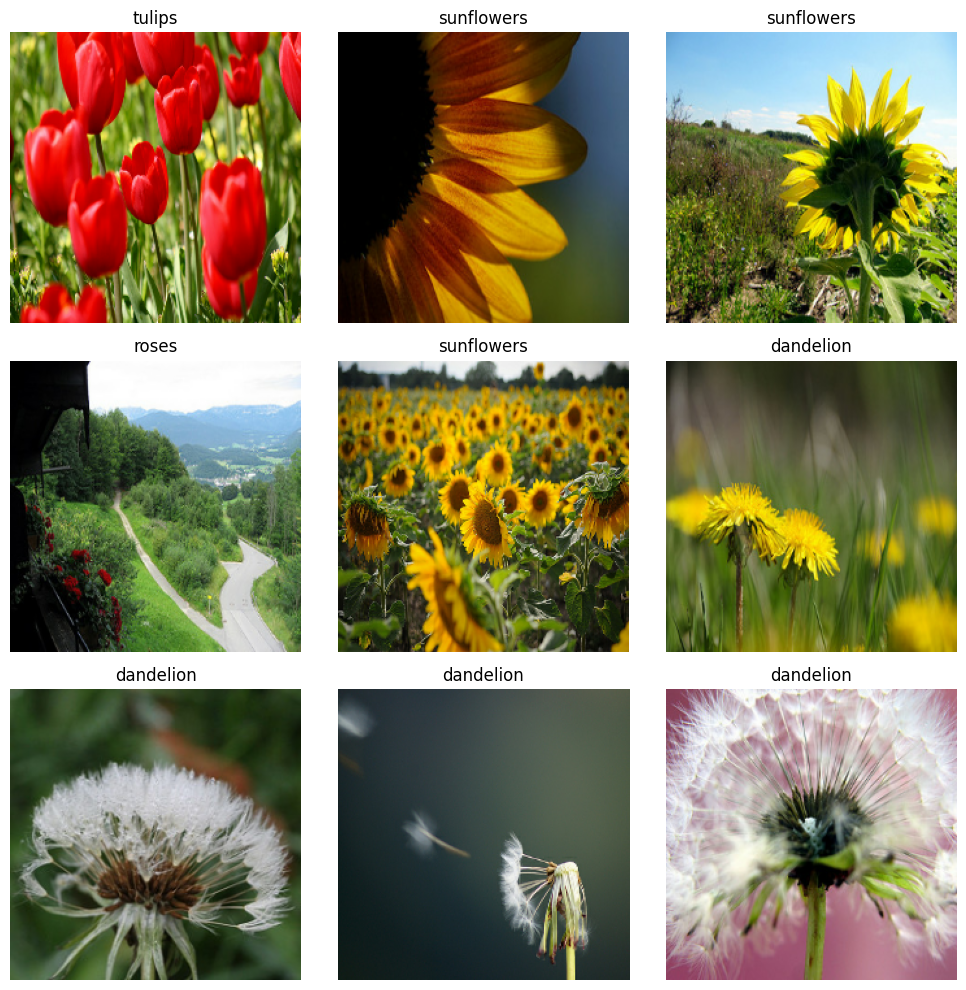

In [5]:
# Fix dataset batching and visualization
def preprocess_image(image, label):
    # Resize and rescale image
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

# Create clean pipeline
train_ds_clean = tfds.load(
    dataset_name,
    split="train[:80%]",
    as_supervised=True,
)

# Take 9 images for visualization
sample_images, sample_labels = [], []
for img, label in train_ds_clean.take(9):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    sample_images.append(img)
    sample_labels.append(label)

# Visualize
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.title(dataset_info.features['label'].names[sample_labels[i].numpy()])
    plt.axis('off')
plt.tight_layout()
plt.show()

## Create Training Pipeline
Recreate the training and validation datasets with proper batch handling using the fixed preprocessing pipeline.

In [6]:
# Now create proper training pipeline
train_ds = tfds.load(
   dataset_name,
   split="train[:80%]",
   as_supervised=True,
).map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

validation_ds = tfds.load(
   dataset_name,
   split="train[80%:]",
   as_supervised=True,
).map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Load BiT from TensorFlow Hub
Load the BiG-Transfer model from TensorFlow Hub as a feature extractor (non-trainable) and add a classification layer for our specific task.

In [23]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"   # must be set first!

import tensorflow as tf
import tensorflow_hub as hub


In [25]:
# 1) (once per environment) install the compatibility package
!pip install -U "tf_keras~=2.17"   # ← match the TF minor version you use

# 2) START A **NEW** PYTHON SESSION or “Runtime → Restart”.
# 3) First lines in the *very first* cell:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"   # must be set before tf import

import tensorflow as tf                 # now tf.keras == Keras-2 (tf-keras)
import tensorflow_hub as hub


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 723.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 77.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
  Attempting uninstall: tf_keras
    Found existing installation: tf_keras 2.18.0
    Uninstalling tf_keras-2.18.0:
      Successfully uninstalled tf_keras-2.18.0
ERROR: pip's de

In [ ]:
IMG_SIZE = 224
num_classes = 5
BIT_MODEL_URL = "https://tfhub.dev/google/bit/m-r50x1/imagenet21k_classification/1"

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(IMG_SIZE, IMG_SIZE, 3)),
    hub.KerasLayer(BIT_MODEL_URL, trainable=False),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])


In [8]:
# Create a simple transfer learning model
base_model = tf.keras.applications.ResNet50(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Freeze the base model
base_model.trainable = False

# Create the model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │        10,245 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Train the Model
Train the transfer learning model for 5 epochs to demonstrate the process. In practice, you might want to train for more epochs.

In [9]:
# Train the model
EPOCHS = 5  # Keep it short for demonstration
history = model.fit(
   train_ds,
   validation_data=validation_ds,
   epochs=EPOCHS,
   verbose=1
)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 264ms/step - accuracy: 0.2804 - loss: 1.6326 - val_accuracy: 0.3542 - val_loss: 1.5119
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.3734 - loss: 1.4912 - val_accuracy: 0.3719 - val_loss: 1.4837
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.3908 - loss: 1.4531 - val_accuracy: 0.3869 - val_loss: 1.4551
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.3968 - loss: 1.4490 - val_accuracy: 0.3515 - val_loss: 1.4592
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.4159 - loss: 1.4212 - val_accuracy: 0.4387 - val_loss: 1.4091
